In [1]:
%matplotlib inline

In [2]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as pltcol

plt.style.use("project_style.mplstyle")

from models import RNNGC, FFGC
from plotting_functions import multiimshow
from dataset import DatasetMaker
from tqdm import tqdm
import spatial_maps as sm

In [3]:
model = RNNGC()
model = model.load("./saved-models/RNNGC_49999.pkl")

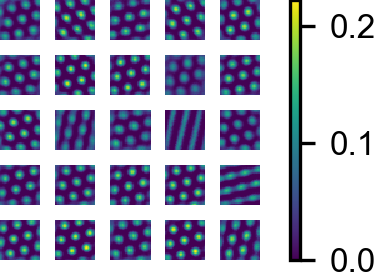

In [4]:
# create data
res = 32
timesteps = 10
dataset = DatasetMaker()
rt, vt = dataset.generate_data(10000, timesteps)
inputs = (rt[:,0], vt)
g = model(inputs).detach().numpy() # double check that states are alright
ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().numpy(), rt[...,1].ravel().numpy(), g.reshape(-1, g.shape[-1]).T, bins = res)[0]
multiimshow(ratemaps[:25]);

In [5]:
grid_scores = np.array([sm.gridness(ratemaps[i]) for i in range(len(ratemaps))])

In [6]:
# sample_size = 10
# samples = 20000

# ci = np.zeros((samples, 2))
# mean_scores = np.zeros(samples)

# for i in range(samples):
#     inds = np.random.choice(len(ratemaps), size = (sample_size), replace=False)
#     ci[i,0] = np.mean(np.diff(ratemaps[inds], axis = (-1))**2/(dr**2))
#     ci[i,1] = np.mean(np.diff(ratemaps[inds], axis = (-2))**2/(dr**2))
#     mean_scores[i] = np.mean(grid_scores[inds])

In [7]:
# plt.plot(mean_scores, ci[:,0], ".", alpha = 0.5)
# plt.plot(mean_scores, ci[:,1], ".", alpha = 0.5)
# plt.xlim([0, 1.3])

In [8]:
# sample_size = 10
# samples = 20000

# dx = np.mean(np.diff(ratemaps, axis = (-1))/(dr**2), axis = (-2, -1))
# dy = np.mean(np.diff(ratemaps, axis = (-2))/(dr**2), axis = (-2, -1))

In [9]:
# plt.plot(grid_scores, dx, "o", alpha = 0.25)
# plt.plot(grid_scores, dy, "o", alpha = 0.25)

In [10]:
x = np.linspace(-1, 1, res)*2*np.pi
y = np.linspace(-1, 1, res)*2*np.pi
xx, yy = np.meshgrid(x,y)
r = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1))

In [11]:
r.shape


torch.Size([1024, 2])

In [12]:
flat_maps = ratemaps.reshape(ratemaps.shape[0], -1).T
flat_maps.shape

(1024, 256)

In [13]:
cutoff = 0.15
score_mask = grid_scores < cutoff
low_gs_maps = flat_maps[:,score_mask]
low_gs_maps = low_gs_maps/np.linalg.norm(low_gs_maps,axis=-1, keepdims = True)

low_gs_loss = model.distance_loss(torch.tensor(low_gs_maps), r).detach().numpy()
low_gs_capacity = model.capacity_loss(torch.tensor(low_gs_maps)).detach().numpy()
low_gs_score = np.mean(grid_scores[score_mask])

In [14]:
sample_size = score_mask.sum()
samples = 1000

mean_scores = np.zeros(samples)
losses = np.zeros(samples)
capacity = np.zeros(samples)

for i in range(samples):
    inds = np.random.choice(model.ng, sample_size, replace = False)
    selected = flat_maps[:,inds]
    selected = selected/np.linalg.norm(selected, axis = -1, keepdims=True)
    losses[i] = model.distance_loss(torch.tensor(selected), r).detach().numpy()
    capacity[i] = model.capacity_loss(torch.tensor(selected)).detach().numpy()
    mean_scores[i] = np.mean(grid_scores[inds])

In [15]:
shuffled_scores = np.zeros(samples)
shuffled_losses = np.zeros(samples)
shuffled_capacity = np.zeros(samples)

for i in range(samples):
    inds = np.random.choice(model.ng, sample_size, replace = False)

    #shuffled_maps = np.random.uniform(0, np.amax(flat_maps), flat_maps.shape).T[inds]
    shuffled_maps = np.array([flat_maps[np.random.choice(len(flat_maps), len(flat_maps), replace= False), i] for i in range(model.ng)])[inds].T
    shuffled_maps = shuffled_maps/np.linalg.norm(shuffled_maps, axis=-1, keepdims = True)
    shuffled_score = [sm.gridness(shuffled_map.reshape(res,res)) for shuffled_map in shuffled_maps.T]

    shuffled_losses[i] = model.distance_loss(torch.tensor(shuffled_maps), r).detach().numpy()
    shuffled_capacity[i] = model.capacity_loss(torch.tensor(shuffled_maps)).detach().numpy()
    shuffled_scores[i] = np.mean(shuffled_score)

In [16]:
def shuffle_color(ax,n):
    [ax.plot() for _ in range(n)]

Text(0, 0.5, 'Distance Loss')

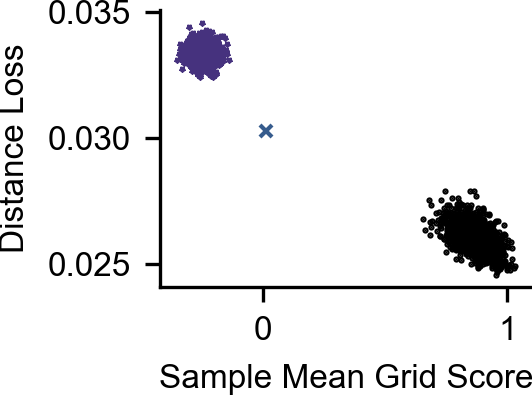

In [17]:
# plt.figure(figsize=(2.75,1.5))
plt.plot(mean_scores, losses, ".k", alpha = 1, label = "Random")
shuffle_color(plt.gca(), 2)
plt.plot(shuffled_scores, shuffled_losses, "*", label = "Random + Shuffled")
shuffle_color(plt.gca(), 1)
plt.plot(np.mean(grid_scores[score_mask]), low_gs_loss, "x", markersize = 3, label = "Low GS")

# plt.legend(frameon = True)
plt.xlabel("Sample Mean Grid Score")
plt.ylabel("Distance Loss")

Text(0, 0.5, 'Capacity Loss')

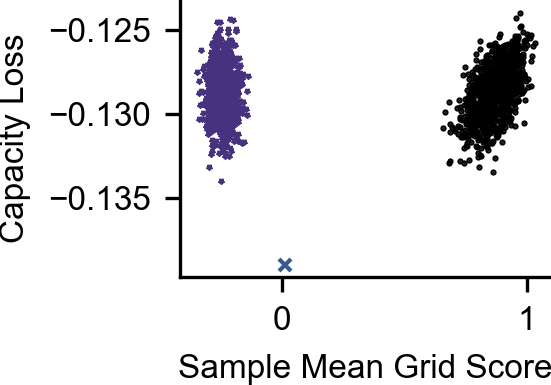

In [18]:
# plt.figure(figsize=(2.75, 1.75))
plt.plot(mean_scores, capacity, ".k", alpha = 1, label = "Random")
shuffle_color(plt.gca(), 2)
plt.plot(shuffled_scores, shuffled_capacity, "*", label = "Random + Shuffled")
shuffle_color(plt.gca(), 1)
plt.plot(low_gs_score, low_gs_capacity, "x", markersize = 3, label = "Low GS")
plt.xlabel("Sample Mean Grid Score")
plt.ylabel("Capacity Loss")
# plt.legend(frameon = True)
